# Multilevel Wavlet Compression In Python

## Demo + Function Notebook

------------------------------------------------------------------------

Artash Nath, Pay-Elec UTAT

5 Febuary 2021

------------------------------------------------------------------------

In [1]:
# Importing Neccesary Libaries

import pywt # For wavlets
import numpy # Handling Array Data
import numpy as np # ^
from PIL import Image # Image Operations
import cv2 # More Image Operations
import matplotlib.pyplot as plt # Plots and displays
from skimage.io import imread # Even more image operations

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Calculate pixel simmilarity between 2 images of same size

def calculate_image_simmilarity(imageA, imageB):
    
    imageA = imageA.astype(np.float32) # Neccesary for the substraction to work
    imageB = imageB.astype(np.float32)
    
    diff = abs(imageA - imageB) # Find difference between 2 images
    
    err = diff.mean() # Calculate Average Difference between those 2 images
    
    return err

    
    
# this function returns a threshold, where all pixels below that threshold should be discareded
# based on the percentage of pixels we want to discard (compression_level)
def get_threshold(im, compression_level):
    thresh = np.sort(abs((im.ravel())))[int(im.size*(1-compression_level))]
    return thresh


In [3]:
def wavlet_compress(image, percent_threshold, level, display_wavlets=False):
    
    # Breaking Image into RGB Layers (Wavlet Compression works on 2D arrays only)
    r = image[:,:,0]
    g = image[:,:,1]
    b = image[:,:,2]
    
    # Compressing each layer into it's wavlet coefficients
    # With the level defined in the function
    r_coeff = pywt.wavedec2(r, 'db2', mode='periodization', level=level)
    g_coeff = pywt.wavedec2(g, 'db2', mode='periodization', level=level)
    b_coeff = pywt.wavedec2(b, 'db2', mode='periodization', level=level)
    
    # Breaking each Coefficient into it's coefficient array, and a metadata variable (doesnt change from image to image, only changed based on original size)
    arr_r, slices_r = pywt.coeffs_to_array(r_coeff)
    arr_g, slices_g = pywt.coeffs_to_array(g_coeff)
    arr_b, slices_b = pywt.coeffs_to_array(b_coeff)
    
    # Getting actual value threshold (below what value of pixel to keep in image) based on percent_threshold provided above
    threshold_r = get_threshold(arr_r, percent_threshold)
    threshold_g = get_threshold(arr_g, percent_threshold)
    threshold_b = get_threshold(arr_b, percent_threshold)
    
    # Compressing each coefficient array based on calculated value threshold 
    arr_r_compressed = arr_r * (abs(arr_r) > (threshold_r))
    arr_g_compressed = arr_g * (abs(arr_g) > (threshold_g))
    arr_b_compressed = arr_b * (abs(arr_b) > (threshold_b))
    
    if display_wavlets:
        plt.figure(figsize=(8,24))
        plt.subplot(311)
        plt.title("Red Level {} Wavlet Coefficients".format(level), fontsize=15)
        plt.imshow(arr_r, cmap='Reds')
        plt.subplot(312)
        plt.title("Green Level {} Wavlet Coefficients".format(level),  fontsize=15)
        plt.imshow(arr_g, cmap='Greens')
        plt.subplot(313)
        plt.title("Blue Level {} Wavlet Coefficients".format(level), fontsize=15)
        plt.imshow(arr_b, cmap='Blues')
        return None
        
    # Converting Compressed Coefficients back into Original Wavlet form (which the pywt library can work with)    
    r_coeff = pywt.array_to_coeffs(arr_r_compressed, slices_r, output_format='wavedecn')
    g_coeff = pywt.array_to_coeffs(arr_g_compressed, slices_g, output_format='wavedecn')
    b_coeff = pywt.array_to_coeffs(arr_b_compressed, slices_b, output_format='wavedecn')
    
    # Using PYWT to uncompress the wavlet coefficients back into their image form
    r_reconstructed = pywt.waverecn(r_coeff, 'db2', mode='periodization').astype(np.uint8)
    g_reconstructed = pywt.waverecn(g_coeff, 'db2', mode='periodization').astype(np.uint8)
    b_reconstructed = pywt.waverecn(b_coeff, 'db2', mode='periodization').astype(np.uint8)
    
    
    # Stacking the uncompressed R. G. B. images into the final RGB image
    reconstructed_im = (np.stack((r_reconstructed, g_reconstructed, b_reconstructed), 2)).astype(np.uint8)
    
    # Calculating average pixel difference between original and uncompressed image
    image_simmilarity = calculate_image_simmilarity(image, reconstructed_im)
    
    return reconstructed_im, image_simmilarity

In [4]:
# Displays Original Image versus Compressed image, just for demo purposes

def display_compression(image, percent_threshold, level):
    
    reconstructed_im, image_simmilarity = wavlet_compress(image, percent_threshold, level)
    
    fig, axs = plt.subplots(1, 2, figsize = (16,8))
    axs[0].imshow(image)
    axs[0].axis('on')
    axs[0].set_title("Original Image")

    axs[1].imshow(reconstructed_im)
    axs[1].axis('off')
    title = "Reconsturcted Image ("+str(percent_threshold*100)+"% Coefficients) "+ "| Pixel Simmilarity : "+str(round(float(image_simmilarity), 3))
    axs[1].set_title(title)
    plt.show()

----------------------------------------------------------------------------------------------------

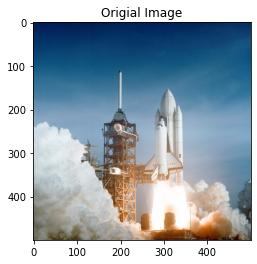

In [5]:
# Loading Sample Image
im = cv2.resize(imread('rocket.jpg')[:1000, :1000], (500,500) )# Read Sample Image
plt.title("Origial Image")
plt.imshow(im)

----------------------------------------------------------------------------------------------------

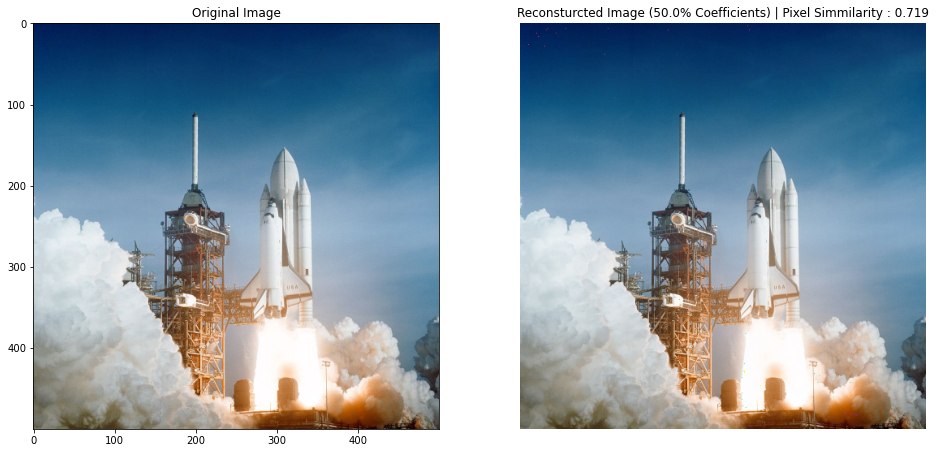

In [6]:
display_compression(im, 0.5, level=1)

----------------------------------------------------------------------------------------------------

# Experimenting around With Wavlet Level

----------------------------------------------------------------------------------------------------

In [7]:
test_levels = list(range(1, 20))

test_level_simmilarities = []

for level in test_levels:
    test_level_simmilarities.append(wavlet_compress(im, 0.5, level=level)[1])
    

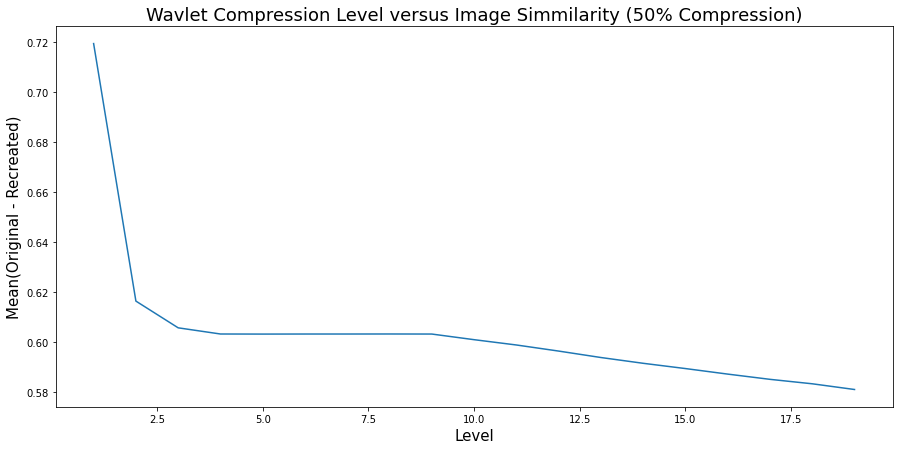

In [8]:
plt.figure(figsize=(15,7))
plt.title("Wavlet Compression Level versus Image Simmilarity (50% Compression)", size=18)
plt.xlabel("Level", size = 15)
plt.ylabel("Mean(Original - Recreated)", size = 15)
plt.plot(test_levels, test_level_simmilarities)

In [9]:
test_levels = np.array(list(range(1, 50)))*20

test_level_simmilarities = []

for level in test_levels:
    test_level_simmilarities.append(wavlet_compress(im, 0.5, level=level)[1])
    

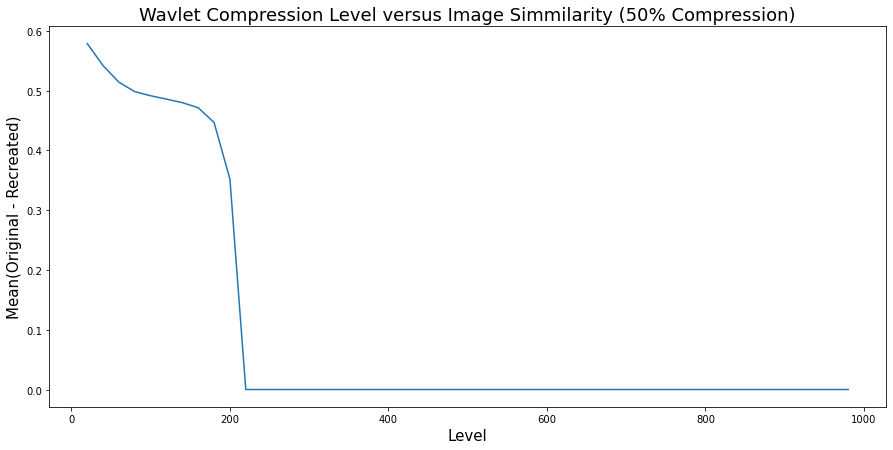

In [10]:
plt.figure(figsize=(15,7))
plt.title("Wavlet Compression Level versus Image Simmilarity (50% Compression)", size=18)
plt.xlabel("Level", size = 15)
plt.ylabel("Mean(Original - Recreated)", size = 15)
plt.plot(test_levels, test_level_simmilarities)

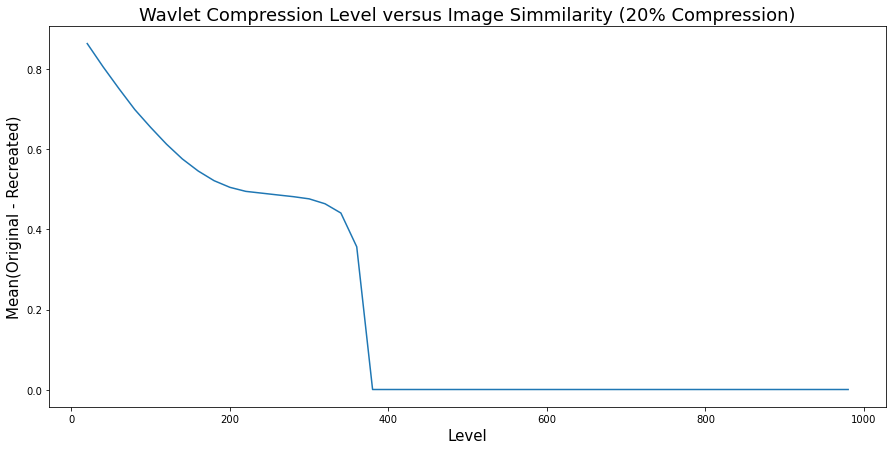

In [13]:
test_levels = np.array(list(range(1, 50)))*20

test_level_simmilarities = []

for level in test_levels:
    test_level_simmilarities.append(wavlet_compress(im, 0.33, level=level)[1])
    
plt.figure(figsize=(15,7))
plt.title("Wavlet Compression Level versus Image Simmilarity (20% Compression)", size=18)
plt.xlabel("Level", size = 15)
plt.ylabel("Mean(Original - Recreated)", size = 15)
plt.plot(test_levels, test_level_simmilarities)
    

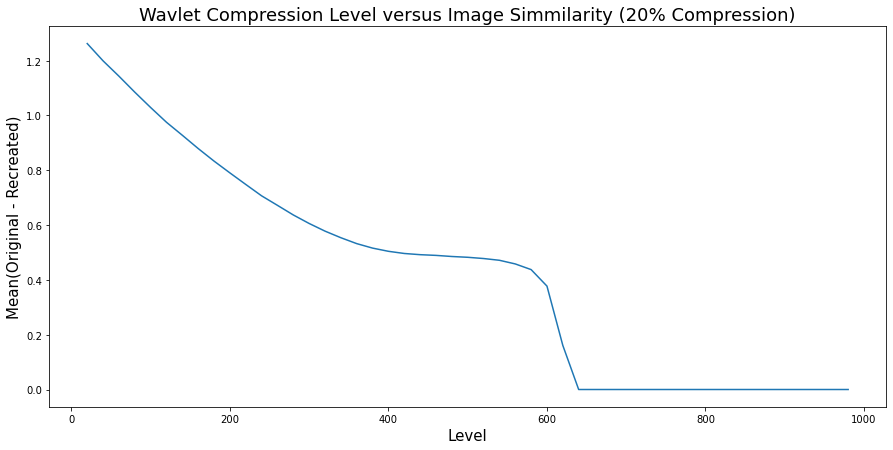

In [14]:
test_levels = np.array(list(range(1, 50)))*20

test_level_simmilarities = []

for level in test_levels:
    test_level_simmilarities.append(wavlet_compress(im, 0.2, level=level)[1])
    
plt.figure(figsize=(15,7))
plt.title("Wavlet Compression Level versus Image Simmilarity (20% Compression)", size=18)
plt.xlabel("Level", size = 15)
plt.ylabel("Mean(Original - Recreated)", size = 15)
plt.plot(test_levels, test_level_simmilarities)
    

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

# Experimenting around With Wavlet Compression Amount
(At Different Levels)

----------------------------------------------------------------------------------------------------

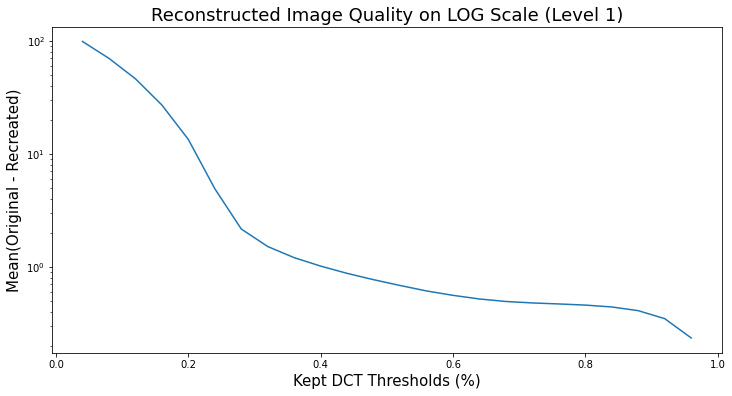

In [31]:
thresholds = np.flip(np.array(list(range(1, 25))))/25

simmilarities = []

for i in thresholds:
    simmilarities.append(wavlet_compress(im, i, level=1)[1])
    
    
plt.figure(figsize=(12,6))

plt.plot(thresholds, simmilarities)

plt.xlabel("Kept DCT Thresholds (%)", size = 15)
plt.ylabel("Mean(Original - Recreated)", size = 15)
plt.title("Reconstructed Image Quality on LOG Scale (Level 1)", size = 18)
plt.yscale('log')


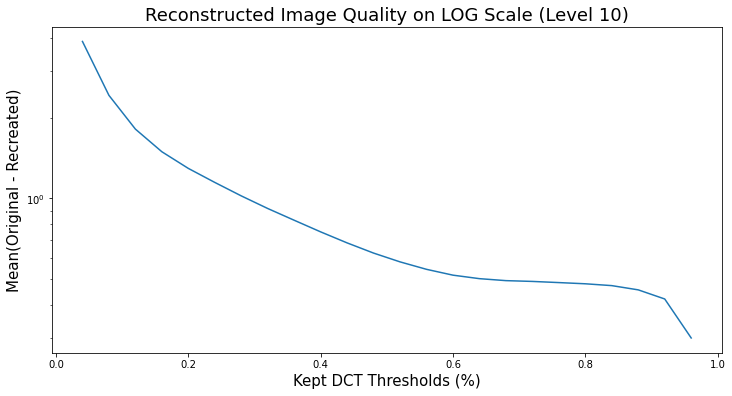

In [32]:
thresholds = np.flip(np.array(list(range(1, 25))))/25

simmilarities = []

for i in thresholds:
    simmilarities.append(wavlet_compress(im, i, level=10)[1])
    
    
plt.figure(figsize=(12,6))

plt.plot(thresholds, simmilarities)

plt.xlabel("Kept DCT Thresholds (%)", size = 15)
plt.ylabel("Mean(Original - Recreated)", size = 15)
plt.title("Reconstructed Image Quality on LOG Scale (Level 10)", size = 18)
plt.yscale('log')

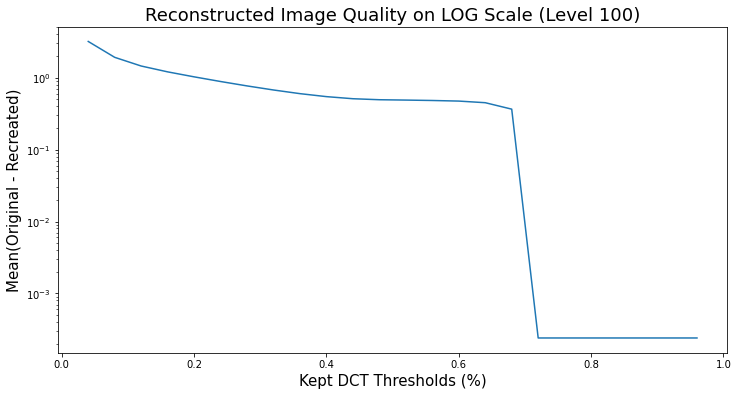

In [33]:
thresholds = np.flip(np.array(list(range(1, 25))))/25

simmilarities = []

for i in thresholds:
    simmilarities.append(wavlet_compress(im, i, level=100)[1])
    
    
plt.figure(figsize=(12,6))

plt.plot(thresholds, simmilarities)

plt.xlabel("Kept DCT Thresholds (%)", size = 15)
plt.ylabel("Mean(Original - Recreated)", size = 15)
plt.title("Reconstructed Image Quality on LOG Scale (Level 100)", size = 18)
plt.yscale('log')

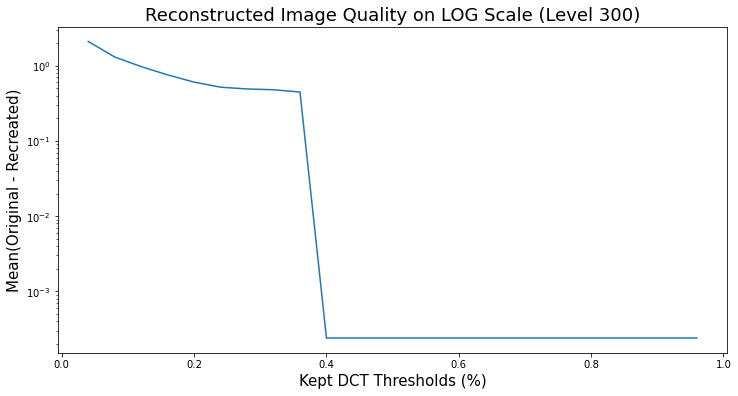

In [34]:
thresholds = np.flip(np.array(list(range(1, 25))))/25

simmilarities = []

for i in thresholds:
    simmilarities.append(wavlet_compress(im, i, level=300)[1])
    
    
plt.figure(figsize=(12,6))

plt.plot(thresholds, simmilarities)

plt.xlabel("Kept DCT Thresholds (%)", size = 15)
plt.ylabel("Mean(Original - Recreated)", size = 15)
plt.title("Reconstructed Image Quality on LOG Scale (Level 300)", size = 18)
plt.yscale('log')

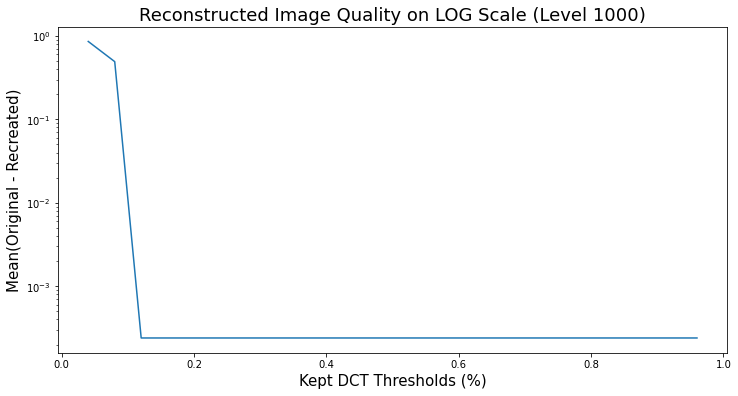

In [36]:
thresholds = np.flip(np.array(list(range(1, 25))))/25

simmilarities = []

for i in thresholds:
    simmilarities.append(wavlet_compress(im, i, level=1000)[1])
    
    
plt.figure(figsize=(12,6))

plt.plot(thresholds, simmilarities)

plt.xlabel("Kept DCT Thresholds (%)", size = 15)
plt.ylabel("Mean(Original - Recreated)", size = 15)
plt.title("Reconstructed Image Quality on LOG Scale (Level 1000)", size = 18)
plt.yscale('log')